In [2]:
import gt4py as gt
from gt4py import gtscript
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.size"] = 16

/users/class170/HPC4WC_venv/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
backend='numpy'

In [4]:
@gtscript.function
def xMid(dx, dt, h, hu):
    return 0.5 * (h[1, 0,0] + h[0,0,0]) - 0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])

@gtscript.function
def yMid(dy1, dt, h, hv1):
    return 0.5 * (h[0,1,0] + h[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])

@gtscript.function
def xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a):
    return (0.5 * (hu[1, 0,0] + hu[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Ux[1,0,0] - Ux[0,0,0]) + \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hv[1,0,0] + hv[0,0,0])))           

@gtscript.function
def yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a):
    return (0.5 * (hu[0,1,0] + hu[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (Uy[0,1,0] - Uy[0,0,0]) + \
        0.5 * dt * \
        (0.5 * (f[0,1,0] + f[0,0,0]) + \
        0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
        (0.5 * (hv[0,1,0] + hv[0,0,0])))

            
@gtscript.function
def xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a):
    return (0.5 * (hv[1, 0,0] + hv[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Vx[1,0,0] - Vx[0,0,0]) - \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hu[1,0,0] + hu[0,0,0])))    
            
            
@gtscript.function
def yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a):
    return (0.5 * (hv[0,1,0] + hv[0,0,0]) \
            - 0.5 * dt / dy1[0,0,0] * (Vy1[0,1,0] - Vy1[0,0,0]) -  \
            0.5 * dt / dy[0,0,0] * (Vy2[0,1,0] - Vy2[0,0,0]) -\
            0.5 * dt * \
            (0.5 * (f[0,1,0] + f[0,0,0]) + \
            0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
            (0.5 * (hu[0,1,0] + hu[0,0,0])))           
            
        
def test_function(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    f: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    tgMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy: gtscript.Field[float],
    dy1: gtscript.Field[float],
    c: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            hu = h * u
            v1 = v * c
            hv = h * v
            hv1 = h * v1
            
            Ux = hu * u + 0.5 * g * h * h
            Uy = hu * v1
            Vx = hu * v
            
            Vy1 = hv * v1
            Vy2 = 0.5 * g * h * h
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            # Mid-point value for h along y
            hMidy = yMid(dx, h, hv, dt)
            
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            huMidy = yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a)
            
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)
            hvMidy = yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a)


In [5]:
def compute_H0(
    h: gtscript.Field[float], 
    h_new: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    cMidy: gtscript.Field[float],
    dxc: gtscript.Field[float],
    dy1c: gtscript.Field[float],
    *,
    dt: float):
    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Update fluid height
        h_new[0,0,0]= h[1,1,0] - \
               dt / dxc[0,0,0] * (huMidx[1,0,0] - huMidx[0,0,0]) - \
               dt /dy1c[0,0,0] * (hvMidy[0,1,0]*cMidy[0,1,0] - hvMidy[0,0,0]*cMidy[0,0,0])
        
        
        
        

In [85]:
def compute_Final_Step(
    h: gtscript.Field[float], 
    hnew: gtscript.Field[float],
    hu: gtscript.Field[float],
    hv: gtscript.Field[float],
    hs: gtscript.Field[float],
    tg: gtscript.Field[float],
    f: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    cMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy1: gtscript.Field[float],
    dxc: gtscript.Field[float],
    dyc: gtscript.Field[float],
    dy1c: gtscript.Field[float],
    unew: gtscript.Field[float],
    vnew: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        # Update fluid height
        hnew[0,0,0]= h[1,1,0] - \
               dt / dxc[0,0,0] * (huMidx[1,0,0] - huMidx[0,0,0]) - \
               dt /dy1c[0,0,0] * (hvMidy[0,1,0]*cMidy[0,1,0] - hvMidy[0,0,0]*cMidy[0,0,0])
        
        #DOES THIS WORK: NP.WHERE WITHIN GT4PY??????
        
        # Update longitudinal moment
        
        temp_bool=hMidx > 0.0        
        UxMid = temp_bool* (huMidx * huMidx / hMidx + 0.5 * g * hMidx * hMidx)
        temp_bool=hMidx <= 0.0
        UxMid=UxMid +  temp_bool*(0.5 * g * hMidx * hMidx)
        
        
        temp_bool=hMidy > 0.0        
        UyMid = temp_bool* (hvMidy * cMidy * huMidy / hMidy)
        
        hunew = hu[1,1,0] - \
                dt / dxc * (UxMid[1,0,0] - UxMid[0,0,0]) - \
                dt / dy1c * (UyMid[0,1,0] - UyMid[0,0,0]) + \
                dt * (f[1,1,0] + \
                            0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                            tg /a) * \
                0.25 * (hvMidx[0,0,0] + hvMidx[1,0,0] + hvMidy[0,0,0] + hvMidy[0,1,0]) - \
                dt * g * \
                0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * \
                (hs[2,0,0] - hs[0,0,0]) / (dx[0,0,0] + dx[1,0,0])
        
        # Update latitudinal moment
        temp_bool=hMidx > 0.0
        VxMid = temp_bool * (hvMidx * huMidx / hMidx)
                            
        temp_bool=hMidy > 0.0
        Vy1Mid = temp_bool * (hvMidy * hvMidy / hMidy * cMidy)
        
        
        Vy2Mid = 0.5 * g * hMidy * hMidy
        hvnew=0.0
 
        hvnew = hv[1,1,0] - \
                dt / dxc * (VxMid[1,0,0] - VxMid[0,0,0]) - \
                dt / dy1c * (Vy1Mid[0,1,0] - Vy1Mid[0,0,0]) - \
                dt / dyc * (Vy2Mid[0,1,0] - Vy2Mid[0,0,0]) - \
                dt * (f[0,0,0] + \
                            0.25 * (huMidx[0,0,0] / hMidx[0,0,0] + \
                                    huMidx[1,0,0] / hMidx[1,0,0] + \
                                    huMidy[0,0,0] / hMidy[0,0,0] + \
                                    huMidy[0,1,0] / hMidy[0,1,0]) * \
                            tg / a) * \
                0.25 * (huMidx[0,0,0] + huMidx[1,0,0] + huMidy[0,0,0] + huMidy[0,1,0]) - \
                            dt * g * \
                0.25 * (hMidx[0,0,0] + hMidx[1,0,0] + hMidy[0,0,0] + hMidy[0,1,0]) * \
                (hs[1,2,0] - hs[1,0,0]) / (dy1[1,1,0] + dy1[1,0,0]) #Klopt dit laatste?

        # Come back to original variables
        unew = hunew / hnew
        vnew = hvnew / hnew
            

In [86]:
test_it = gtscript.stencil(definition=test_function, backend=backend, externals={"xMid": xMid, "yMid": yMid, "xMid_hu": xMid_hu, "yMid_hu": yMid_hu, "xMid_hv": xMid_hv, "yMid_hv": yMid_hv})
H0 = gtscript.stencil(definition=compute_H0, backend=backend)
compFS = gtscript.stencil(definition=compute_Final_Step, backend=backend)


In [87]:
# grid size
nx = 10
ny = 10
nz=1

backend='numpy'

# storage shape
shape = (nx, ny, nz)

# default origin (trust it for now!)
default_origin = (0, 0,0)

In [88]:
shape

(10, 10, 1)

(10, 10, 1)


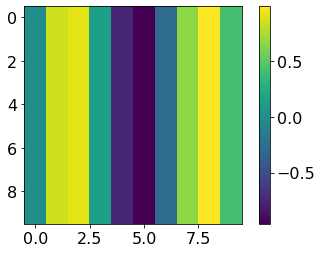

In [89]:
h=[np.sin(np.arange(nx)),]*ny
h=np.expand_dims(h, axis=2)
plt.imshow(h)
plt.colorbar()
print(np.shape(h))

In [90]:
# allocate a storage filled with ones
u = gt.storage.ones(backend, default_origin, shape, dtype=float)
v = gt.storage.ones(backend, default_origin, shape, dtype=float)

hMidx = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)
hMidy = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)

huMidx = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)
huMidy = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)

hvMidx = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)
hvMidy = gt.storage.from_array(np.ones((nx-1, ny-1, nz)), backend, default_origin)


h=[np.sin(np.arange(nx)),]*ny
h=np.expand_dims(h, axis=2)
h = gt.storage.from_array(h, backend, default_origin)
h_new = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)

f = gt.storage.from_array(np.ones(shape), backend, default_origin)

tgMidx = gt.storage.from_array(np.ones((nx-1, ny, nz)), backend, default_origin)
tgMidy = gt.storage.from_array(np.ones((nx,ny-1, nz)), backend, default_origin)

cMidy = gt.storage.from_array(np.ones((nx-1,ny-1, nz)), backend, default_origin)

dx = gt.storage.from_array(np.ones((nx-1, ny, nz)), backend, default_origin)
dy = gt.storage.from_array(np.ones((nx,ny-1, nz)), backend, default_origin)
dy1 = gt.storage.from_array(np.ones((nx,ny-1, nz)), backend, default_origin)

dxc = gt.storage.from_array(np.ones((nx-2,ny-2, nz)), backend, default_origin)
dy1c = gt.storage.from_array(np.ones((nx-2,ny-2, nz)), backend, default_origin)

c = gt.storage.from_array(np.ones(shape), backend, default_origin)

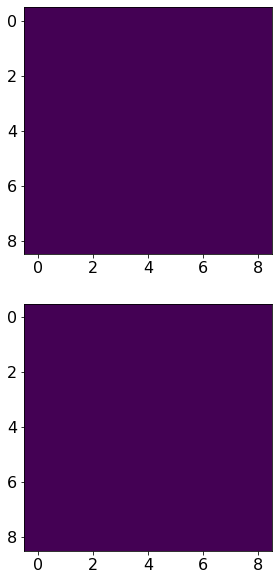

In [91]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(np.asarray(hMidx))
plt.subplot(2,1,2)
plt.imshow(np.asarray(hMidy))

In [92]:
test_it(
    u, 
    v,
    hMidx,
    hMidy,
    huMidx,
    huMidy,
    hvMidx,
    hvMidy,
    h,
    h_new,
    f,
    tgMidx,
    tgMidy,
    dx,
    dy,
    dy1,
    c,
    dt=1.0,
    g=9.81,
    a=1.0,
    origin=(0,0,0), domain=(nx-1, ny-1, nz))

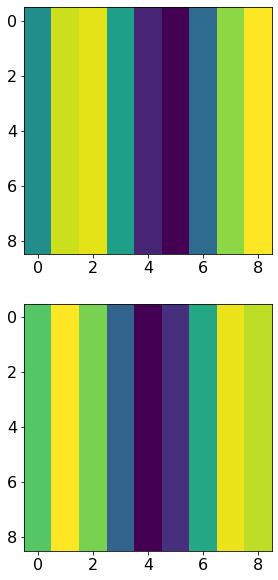

In [93]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(np.asarray(hMidx))
plt.subplot(2,1,2)
plt.imshow(np.asarray(hMidy))

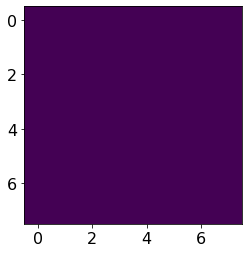

In [94]:
h_new = gt.storage.from_array(np.zeros((nx-2, ny-2, nz)), backend, default_origin)

plt.imshow(np.asarray(h_new))

In [98]:
H0(h, 
   h_new,
   huMidx, hvMidy,
   cMidy, dxc,
   dy1c,
   dt=1.0, origin=(0,0,0), domain=(nx-2, ny-2, nz))

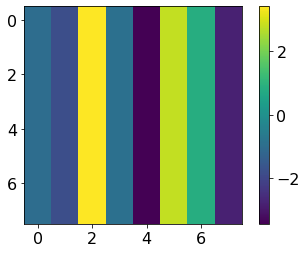

In [99]:
plt.imshow(np.asarray(h_new))
plt.colorbar()

In [100]:
np.shape(vnew)

(10, 10, 1)

In [101]:
hnew = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)
hu = gt.storage.from_array(np.ones(shape), backend, default_origin)
hv = gt.storage.from_array(np.ones(shape), backend, default_origin)
hs = gt.storage.from_array(np.ones(shape), backend, default_origin)
tg = gt.storage.from_array(np.ones(shape), backend, default_origin)
dyc = gt.storage.from_array(np.ones(shape), backend, default_origin)
unew = gt.storage.from_array(np.ones(shape), backend, default_origin)
vnew = gt.storage.from_array(np.ones(shape), backend, default_origin)

compFS(h, 
    hnew,
    hu,
    hv,
    hs,
    tg,
    f,
    huMidx,
    huMidy,
    hvMidx,
    hvMidy,
    hMidx,
    hMidy,
    cMidy,
    dx,
    dy1,
    dxc,
    dyc,
    dy1c,
    unew,
    vnew,
    g=9.81,
    a=1.0,
    dt=1.0, origin=(0,0,0), domain=(nx-2, ny-2, nz))

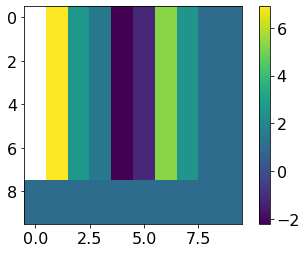

In [105]:
plt.imshow(np.asarray(vnew[:,:,0]))
plt.colorbar()

In [ ]:
# --- Auxiliary variables --- #

v1	= v * self.c
hu	= h * u
hv	= h * v
hv1 = h * v1

# --- Compute mid-point values after half timestep --- #

# Mid-point value for h along x
hMidx = 0.5 * (h[1:,1:-1] + h[:-1,1:-1]) - \
     0.5 * self.dt / self.dx[:,1:-1] * (hu[1:,1:-1] - hu[:-1,1:-1])

# Mid-point value for h along y
hMidy = 0.5 * (h[1:-1,1:] + h[1:-1,:-1]) - \
     0.5 * self.dt / self.dy1[1:-1,:] * (hv1[1:-1,1:] - hv1[1:-1,:-1])

# Mid-point value for hu along x
Ux = hu * u + 0.5 * self.g * h * h
huMidx = 0.5 * (hu[1:,1:-1] + hu[:-1,1:-1]) - \
        0.5 * self.dt / self.dx[:,1:-1] * (Ux[1:,1:-1] - Ux[:-1,1:-1]) + \
        0.5 * self.dt * \
        (0.5 * (self.f[1:,1:-1] + self.f[:-1,1:-1]) + \
        0.5 * (self.u[1:,1:-1] + self.u[:-1,1:-1]) * self.tgMidx / self.a) * \
        (0.5 * (hv[1:,1:-1] + hv[:-1,1:-1]))

# Mid-point value for hu along y
Uy = hu * v1
huMidy = 0.5 * (hu[1:-1,1:] + hu[1:-1,:-1]) - \
        0.5 * self.dt / self.dy1[1:-1,:] * (Uy[1:-1,1:] - Uy[1:-1,:-1]) + \
        0.5 * self.dt * \
        (0.5 * (self.f[1:-1,1:] + self.f[1:-1,:-1]) + \
        0.5 * (u[1:-1,1:] + u[1:-1,:-1]) * self.tgMidy / self.a) * \
        (0.5 * (hv[1:-1,1:] + hv[1:-1,:-1]))

# Mid-point value for hv along x
Vx = hu * v
hvMidx = 0.5 * (hv[1:,1:-1] + hv[:-1,1:-1]) - \
        0.5 * self.dt / self.dx[:,1:-1] * (Vx[1:,1:-1] - Vx[:-1,1:-1]) - \
        0.5 * self.dt * \
        (0.5 * (self.f[1:,1:-1] + self.f[:-1,1:-1]) + \
        0.5 * (u[1:,1:-1] + u [:-1,1:-1]) * self.tgMidx / self.a) * \
        (0.5 * (hu[1:,1:-1] + hu[:-1,1:-1]))

# Mid-point value for hv along y
Vy1 = hv * v1
Vy2 = 0.5 * self.g * h * h
hvMidy = 0.5 * (hv[1:-1,1:] + hv[1:-1,:-1]) - \
        0.5 * self.dt / self.dy1[1:-1,:] * (Vy1[1:-1,1:] - Vy1[1:-1,:-1]) - \
        0.5 * self.dt / self.dy[1:-1,:] * (Vy2[1:-1,1:] - Vy2[1:-1,:-1]) - \
        0.5 * self.dt * \
        (0.5 * (self.f[1:-1,1:] + self.f[1:-1,:-1]) + \
        0.5 * (u[1:-1,1:] + u[1:-1,:-1]) * self.tgMidy / self.a) * \
        (0.5 * (hu[1:-1,1:] + hu[1:-1,:-1]))


## Final functions for swes

In [ ]:
#Compute x staggered


def x_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    f: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    tgMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy: gtscript.Field[float],
    dy1: gtscript.Field[float],
    c: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            hu = h * u
            v1 = v * c
            hv = h * v
            hv1 = h * v1
            
            Ux = hu * u + 0.5 * g * h * h
            Uy = hu * v1
            Vx = hu * v
            
            Vy1 = hv * v1
            Vy2 = 0.5 * g * h * h
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)
    
    

def y_staggered_first_step(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    f: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    tgMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy: gtscript.Field[float],
    dy1: gtscript.Field[float],
    c: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            # Mid-point value for h along y
            hMidy = yMid(dy1, h, hv, dt)
            huMidy = yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a)
            hvMidy = yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a)











@gtscript.function
def xMid(dx, dt, h, hu):
    return 0.5 * (h[1, 0,0] + h[0,0,0]) - 0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])

@gtscript.function
def yMid(dy1, dt, h, hv1):
    return 0.5 * (h[0,1,0] + h[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])

@gtscript.function
def xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a):
    return (0.5 * (hu[1, 0,0] + hu[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Ux[1,0,0] - Ux[0,0,0]) + \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hv[1,0,0] + hv[0,0,0])))           

@gtscript.function
def yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a):
    return (0.5 * (hu[0,1,0] + hu[0,0,0]) - 0.5 * dt / dy1[0,0,0] * (Uy[0,1,0] - Uy[0,0,0]) + \
        0.5 * dt * \
        (0.5 * (f[0,1,0] + f[0,0,0]) + \
        0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
        (0.5 * (hv[0,1,0] + hv[0,0,0])))

            
@gtscript.function
def xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a):
    return (0.5 * (hv[1, 0,0] + hv[0,0,0]) - 0.5 * dt / dx[0,0,0] * (Vx[1,0,0] - Vx[0,0,0]) - \
            0.5 * dt * \
            (0.5 * (f[1,0,0] + f[0,0,0]) + \
            0.5 * (u[1,0,0] + u[0,0,0]) * tgMidx / a) * \
            (0.5 * (hu[1,0,0] + hu[0,0,0])))    
            
            
@gtscript.function
def yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a):
    return (0.5 * (hv[0,1,0] + hv[0,0,0]) \
            - 0.5 * dt / dy1[0,0,0] * (Vy1[0,1,0] - Vy1[0,0,0]) -  \
            0.5 * dt / dy[0,0,0] * (Vy2[0,1,0] - Vy2[0,0,0]) -\
            0.5 * dt * \
            (0.5 * (f[0,1,0] + f[0,0,0]) + \
            0.5 * (u[0,1,0] + u[0,0,0]) * tgMidy / a) * \
            (0.5 * (hu[0,1,0] + hu[0,0,0])))           
            
        
def test_function(
    u: gtscript.Field[float], 
    v: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    huMidy: gtscript.Field[float],
    hvMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    f: gtscript.Field[float],
    tgMidx: gtscript.Field[float],
    tgMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy: gtscript.Field[float],
    dy1: gtscript.Field[float],
    c: gtscript.Field[float],
    *,
    dt: float,
    g: float,
    a: float):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import xMid, yMid, xMid_hu, yMid_hu, xMid_hv, yMid_hv
    
    with computation(PARALLEL), interval(...):
            hu = h * u
            v1 = v * c
            hv = h * v
            hv1 = h * v1
            
            Ux = hu * u + 0.5 * g * h * h
            Uy = hu * v1
            Vx = hu * v
            
            Vy1 = hv * v1
            Vy2 = 0.5 * g * h * h
            
            # Mid-point value for h along x
            hMidx = xMid(dx, h, hu, dt)
            # Mid-point value for h along y
            hMidy = yMid(dx, h, hv, dt)
            
            huMidx = xMid_hu(dx, dt, hu, hv, Ux, f, u, tgMidx, a)
            huMidy = yMid_hu(dy1, dt, hu, hv, Uy, f, u, tgMidy, a)
            
            hvMidx = xMid_hv(dx, dt, hu, hv, Vx, f, u, tgMidx, a)
            hvMidy = yMid_hv(dy1, dy, dt, hu, hv,  Vy1, Vy2, f, u, tgMidy, a)